# Name : Kindle Zhang

# Summary of the SuSiE method

SuSiE (Sum of Single Effects) is a Bayesian sparse regression model designed for variable selection, particularly in fine-mapping genetic studies. Unlike traditional methods that select individual SNPs, SuSiE identifies credible sets of variants, effectively handling correlation among SNPs. By using Bayesian stepwise selection, it improves both efficiency and accuracy, ensuring that the selected set contains the true causal variant while accounting for uncertainty. One key advantage is that SuSiE allows the incorporation of prior probabilities to influence results, making it adaptable to different assumptions. Additionally, even when genotype data is unavailable, SuSiE can infer causal variants by adjusting the LD matrix to obtain a correlation matrix. This flexibility, combined with its probabilistic confidence estimation and computational efficiency, makes SuSiE a powerful tool for fine-mapping and high-dimensional variable selection, outperforming traditional approaches in genetic studies.

# Overview

This fine-mapping tutorial was developed using simulated data shipped with [`susieR`](https://github.com/stephenslab/susieR) package.
The simulated data contains simulated phenotype matrix $Y$ in $N \approx 600$ individuals. 
The goal is to identify from the genotype matrix $X_{N\times P}$ ($P=1000$) the genetic variables that directly cause changes in the phenotypic values.

**There are several questions throughout the notebook, and please answer each of them by adding cells (in Markdown or R) under the question and keep the code you use there as well.**

The simulated data-set is [available
here](https://github.com/stephenslab/susieR/blob/master/data/N3finemapping.RData),
as part of the `susieR` package. In this tutorial we will first explore the data with conventional univariate association analysis,
then perform preliminary fine-mapping analysis under simplified 
assumptions to illustrate the idea of statistical fine-mapping, and finally use the R package `susieR` to perform formal Bayesian fine-mapping analysis.
We will also discuss fine-mapping using association summary statistics.

# Explore the association data-set

First let's install the package `susieR` according to [its Github repo](https://github.com/stephenslab/susieR) and `corrplot` to draw some plots later. This may take a while.

In [2]:
install.packages("susieR")
install.packages("corrplot")

package 'susieR' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\zhang\AppData\Local\Temp\RtmpwVwyRV\downloaded_packages
package 'corrplot' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\zhang\AppData\Local\Temp\RtmpwVwyRV\downloaded_packages


Please execute the following code cell to load the simulated data.

In [1]:
rm(list=ls())
library(susieR)
library(corrplot)
data(N3finemapping)
attach(N3finemapping)

Warning message:
"package 'susieR' was built under R version 4.3.3"
Warning message:
"package 'corrplot' was built under R version 4.3.3"
corrplot 0.95 loaded



In [2]:
ls()

[1] "N3finemapping"

The loaded dataset, `N3finemapping`, contains regression data $X$ and $Y$, 
along with some other relevant attributes in the context of genetic studies. It also
contains the "true" regression coefficients the data is simulated from.

In [3]:
names(N3finemapping)

[1] "X"                 "chrom"             "pos"              
[4] "true_coef"         "residual_variance" "Y"                
[7] "allele_freq"       "V"

In [4]:
dim(X)
head(X)

[1]  574 1001

-0.02090592,0.4738676,0.1620209,-0.05226481,-0.1637631,-0.026472457,0.1689895,-0.2421603,0.1585366,-0.1567944,⋯,-0.4006969,-1.09254036,-0.4119346,-0.2857143,-0.3885017,-0.3919861,-0.3969795,-0.02090592,-0.2844549,-0.3883308
-0.02090592,-0.5261324,1.1620209,-0.05226481,-0.1637631,0.006059281,1.1689895,-0.2421603,1.1585366,-0.1567944,⋯,-0.4006969,-1.09254036,-0.4119346,-0.2857143,-0.3885017,-0.3919861,-0.3969795,-0.02090592,-0.2844549,-0.3883308
-0.02090592,-0.5261324,1.1620209,-0.05226481,-0.1637631,-0.026472457,1.1689895,-0.2421603,1.1585366,-0.1567944,⋯,0.5993031,-0.09254036,0.5880654,-0.2857143,-0.3885017,-0.3919861,0.6030205,-0.02090592,-0.2844549,-0.3883308
-0.02090592,0.4738676,0.1620209,-0.05226481,-0.1637631,-0.026472457,0.1689895,-0.2421603,0.1585366,-0.1567944,⋯,-0.4006969,-1.09254036,-0.4119346,-0.2857143,-0.3885017,-0.3919861,-0.3969795,-0.02090592,-0.2844549,-0.3883308
-0.02090592,-0.5261324,1.1620209,-0.05226481,-0.1637631,-0.026472457,1.1689895,-0.2421603,1.1585366,-0.1567944,⋯,-0.4006969,-1.09254036,-0.4119346,-0.2857143,-0.3885017,-0.3919861,-0.3969795,-0.02090592,-0.2844549,-0.3883308
-0.02090592,-0.5261324,0.1620209,-0.05226481,-0.1637631,-0.026472457,0.1689895,0.7578397,0.1585366,-0.1567944,⋯,-0.4006969,-1.09254036,-0.4119346,-0.2857143,-0.3885017,-0.3919861,-0.3969795,-0.02090592,-0.2844549,-0.3883308


-----------------------------------------

**Example question: in the genotype matrix `X`, how many individuals and the genetic variants are included? What is the genotype value for the 100th variant of the 21st individual?**

**Example answer:** The genotype matrix has 574 individuals and 1001 genetic variants. The genotype value for the 100th variant of the 21st individual is 0.4408.

In [5]:
dim(X)

[1]  574 1001

In [6]:
X[21, 100]

[1] 0.4407666

-----------------------------------------

The phenotype matrix contains values for the 574 individuals for 2 traits,

In [9]:
dim(Y)

[1] 574   2

We focus on the first trait, let

In [6]:
y = Y[,1]
b = true_coef[,1]

There are 3 "causal" variants for this trait,

In [7]:
which(b != 0)

[1] 403 653 773

Note: in this tutorial we will avoid the phrase "causal", and use "effect variable" to refer to the variants having true non-zero effects on the phenotype.

-----------------------------------------

**Question 1: Please use R function `plot` to visualize the true effects vector. What are the effect sizes for these 3 "causal" variants?**

**Answer:** 
the effect size for these 3 "causal" variants are 1.189172, -0.831789 and 1.399288.

[1]  1.189172 -0.831789  1.399288


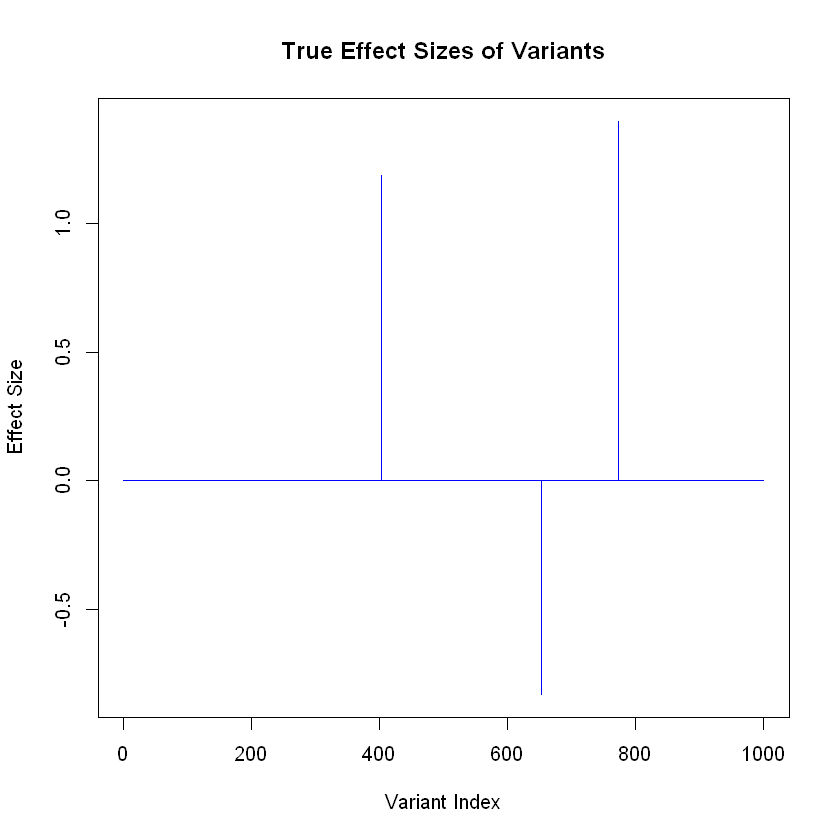

In [8]:
plot(
  b,
  type = "h",
  col = "blue",
  main = "True Effect Sizes of Variants",
  xlab = "Variant Index",
  ylab = "Effect Size"
)

effect_sizes = b[which(b != 0)]
print(effect_sizes)

-----------------------------------------

# Association testing via simple linear regression

`univariate_regression` function in `susieR` can be used to perform association testing 
by fitting univariate simple regression for each variable separately.
The results are $\hat{\beta}$ for effect size estimates, and their standard errors $SE(\hat{\beta})$.

In [9]:
sumstats <- univariate_regression(X, y)

-----------------------------------------

**Question 2: Please use R function plot to compare the true effects variable `b` with the estimated effect sizes `sumstats$betahat`. Are they consistent, and why?**

**Answer:**

In [10]:
effect_sizes
sumstats$betahat[which(b != 0)]

[1]  1.189172 -0.831789  1.399288

[1]  1.285890 -1.126053  1.421208

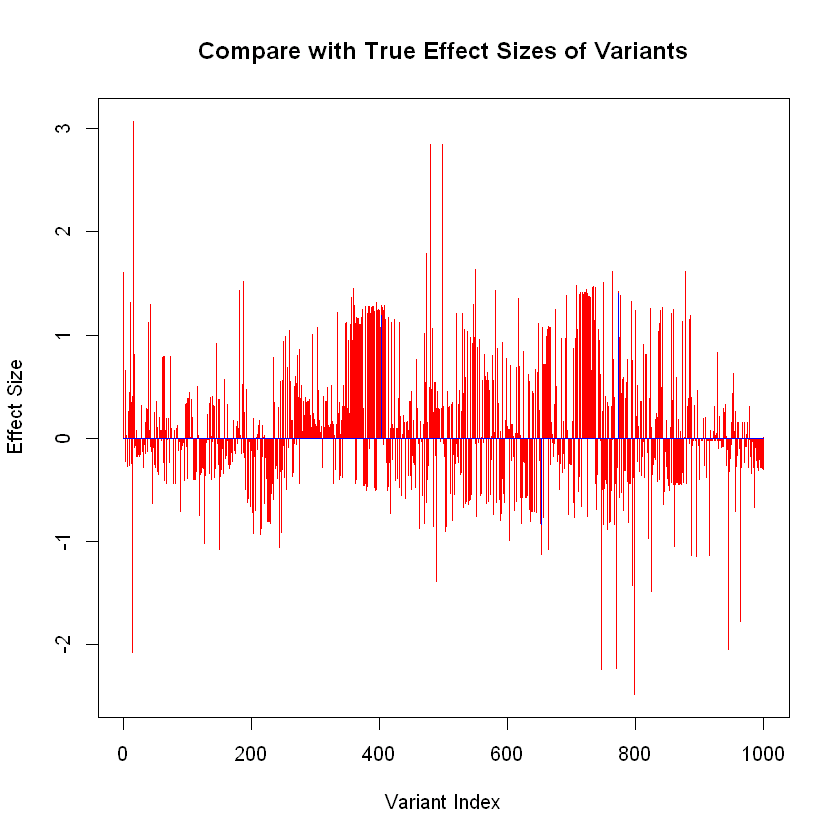

In [11]:
plot(
  sumstats$betahat,
  type = "h",
  col = "red",
  main = "Compare with True Effect Sizes of Variants",
  xlab = "Variant Index",
  ylab = "Effect Size"
)
lines(b, type = "h", col = "blue")

According to the plot and the compare result, the three "causal" variants' effect size are similar with the true effect size. However, this method assigns effects to variants that actually had no effect, possibly because the regressions were conducted independently, ignoring the correlations between variants.

-----------------------------------------

z-scores can be derived from these quantities; $-log_{10}$ p-values can then becomputed from z-scores, 

In [12]:
z_scores <- sumstats$betahat / sumstats$sebetahat
log10p <- -log10(pchisq(z_scores^2,1,lower.tail=F))

-----------------------------------------

**Question 3: How many variables have p-values smaller than $5 \times 10^{-8}$? How would you interpret those variants based on the univariate association analysis?**


**Answer:**

In [13]:
length(which(log10p > -log10(5 * 10 ^ (-8))))

[1] 8

only 8 variables have p-values smaller than 5e-8. 
At a confidence level of 1-5e-8, we can conclude that the variants of these eight genes are each associated with the phenotype.

**Question 4: What's the correlation between these variables (with p-values smaller than $5 \times 10^{-8}$) in the original genotype data `X`? Draw a correlogram and print out the pair with highest positive correlation. What does it mean for those two variants?**

**Answer:**

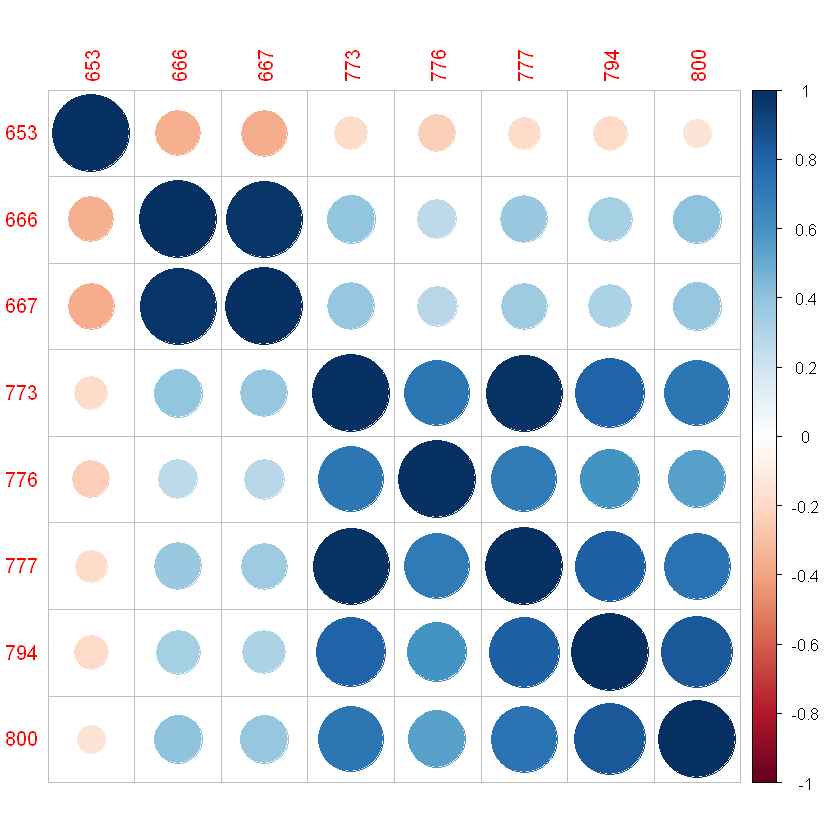

In [14]:
X_matrix = X[,which(log10p > -log10(5 * 10 ^ (-8)))]
colnames(X_matrix) = which(log10p > -log10(5 * 10 ^ (-8)))
cor_matrix = cor(X_matrix, use = "pairwise.complete.obs")
corrplot(cor_matrix)

We can observe that variants 666 and 667, as well as variants 773 and 777, exhibit a clear linear correlation. 
Among them, variants 773 and 777 show a stronger correlation, indicating that these two variants share many similarities in influencing gene expression.

-----------------------------------------

`susieR` package provides a plot function to generate Manhattan plot for the association test results. Notice that the true effect variables are labelled in red (true effects provided to `susie_plot` via setting `b=` parameter),

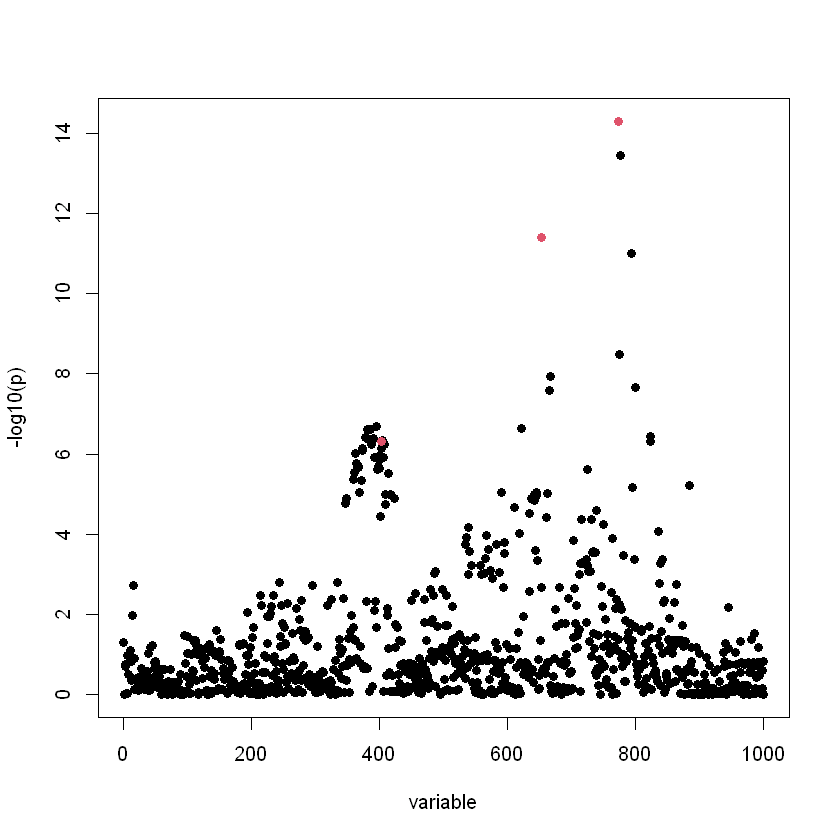

In [15]:
susie_plot(z_scores,y="z",b=b)

As shown on this plot, the "lead" SNP (the one with smallest p-value) is indeed one of the true effect variables. However, the 2nd most significant SNP is not one of the other two effect variables, and there are many other SNPs having p-values smaller than $5 \times 10^{-8}$, a widely accepted significant level threshold for genetic association studies.

-----------------------------------------

**Question 5: What index is the second most significant SNP? Is it one of the other two true effect variables? What would you say about the relationship between the top and 2nd most significant SNPs?**


**Answer:**

In [18]:
sec_SNP = which(log10p == sort(log10p, decreasing = TRUE)[2])
sec_SNP
sec_SNP %in% which(b != 0)

[1] 777

[1] FALSE

The second most dignificant SNP is 777. It's not the other two true effect variables. 

As we just observed, variants 773 and 777 exhibit significant correlation, suggesting that they may serve similar functions in gene expression and can be considered as a single true variant.

-----------------------------------------

# "One causal variant" assumption for fine-mapping

Under the assumption that there is only one true effect in the region of interest, fine-mapping does not have to use linkage disequilibrium (LD) information between variables. It can be performed by simply calculating the likelihood of the association model for each variable separately, then computing the probability for a variable being the true effect as the ratio of its likelihood over the sum of likelihoods over all variables. We use linear regression `lm` in R to compute the log-likelihood,

In [20]:
lliks = sapply(1:ncol(X), function(i) logLik(lm(y~X[,i])))

Then compute the probability for each variable being the true effect variable: 

In [21]:
lliks = lliks - max(lliks) # To avoid taking exp on large numbers in the next line, thus improving numerical stability 
probs = exp(lliks)/sum(exp(lliks))

We use `susie_plot` function to plot these probabilities computed, and color label the true effect variables:

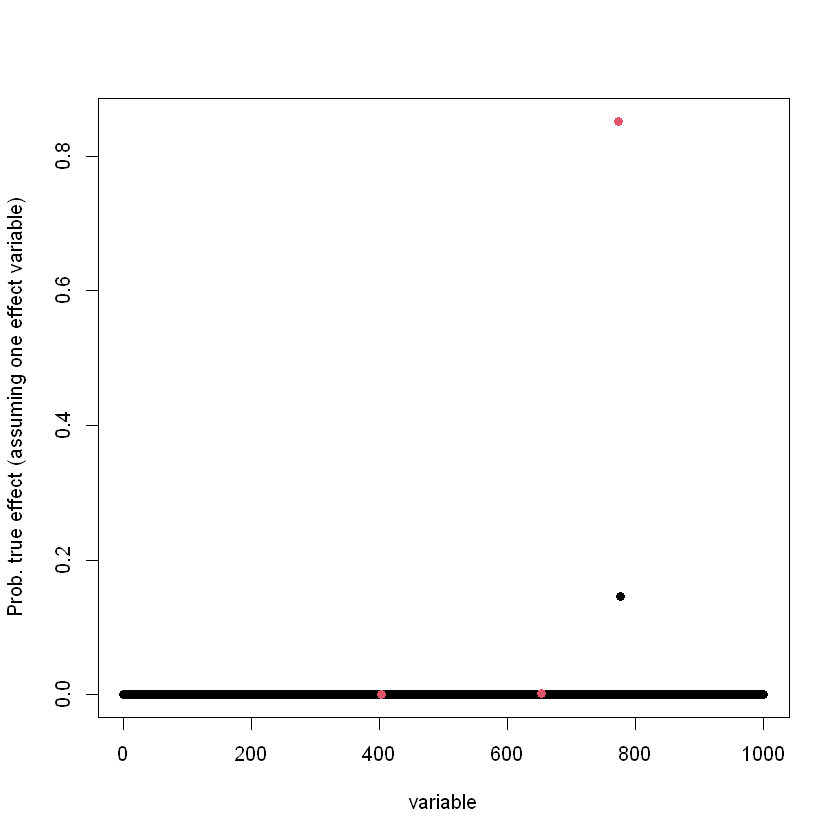

In [22]:
susie_plot(probs, y="PIP", b=b, ylab = "Prob. true effect (assuming one effect variable)")

As expected, under the "one causal variant" assumption, only the lead SNP is identified with over 80% probability of having a non-zero effect. The other two true effect variables in red are not identified.

## 95% credible set for single effect

95% credible set (CS) is defined as a set of variables with 95% probability of containing a true effect. By visually examine the plot above, we can see that the lead SNP has over 80% probability being the true effect, and another SNP near it has almost 20% probability of being the true effect. The 95% credible set should thus contain both of them in order for the coverage to exceed 95%. Indeed, we can formally verify this using an internal function `in_CS` to assess if a variable is in a single effect CS. We report the indices of these variables,

In [23]:
which(susieR:::in_CS(t(probs), coverage = 0.95) != 0)

[1] 773 777

These variables indeed correspond to the two non-zero probability variables on the plot above.

# Fine-mapping with individual level data using Sum of Single Effects model

When multiple true effects are expected, formal statistical fine-mapping via Bayesian Variable Selection
should be performed. We fit a Sum of Single Effects (SuSiE) model implemented in `susieR` package, 
assuming at most 10 causal variables (although SuSiE is robust to the choice of `L`).

In [24]:
fitted <- susie(X, y, L = 10)

HINT: For an X with many columns, please consider installingthe Rfast package for more efficient credible set (CS)calculations.



## 95% credible sets for each single effect

By default, `susie` function computes 95% CS each containing one effect variable,

In [25]:
print(fitted$sets)

$cs
$cs$L2
[1] 653

$cs$L1
[1] 773 777

$cs$L3
 [1] 362 365 372 373 374 379 381 383 384 386 387 388 389 391 392 396 397 398 399
[20] 400 401 403 404 405 407 408 415


$purity
   min.abs.corr mean.abs.corr median.abs.corr
L2    1.0000000     1.0000000       1.0000000
L1    0.9815726     0.9815726       0.9815726
L3    0.8686309     0.9640176       0.9720711

$cs_index
[1] 2 1 3

$coverage
[1] 0.9998236 0.9988858 0.9539811

$requested_coverage
[1] 0.95



The 3 true signals have been captured by the 3 CS reported here. The
3rd CS contains many variables, including the true causal variable
`403`. The minimum absolute correlation is 0.86.

-----------------------------------

**Question 6: Print the credible sets if we use 99% as the coverage. Hint: you may want to check the source code for `susie` function from [here](https://github.com/stephenslab/susieR)**.

**Answer:**

In [27]:
fitted_2 <- susie(X, y, L = 10, coverage = 0.99)
print(fitted_2$sets)

HINT: For an X with many columns, please consider installingthe Rfast package for more efficient credible set (CS)calculations.



$cs
$cs$L2
[1] 653

$cs$L1
[1] 773 777

$cs$L3
 [1] 360 361 362 365 366 367 368 372 373 374 379 381 383 384 386 387 388 389 391
[20] 392 396 397 398 399 400 401 403 404 405 407 408 409 410 415 419


$purity
   min.abs.corr mean.abs.corr median.abs.corr
L2    1.0000000     1.0000000       1.0000000
L1    0.9815726     0.9815726       0.9815726
L3    0.8310851     0.9499450       0.9556871

$cs_index
[1] 2 1 3

$coverage
[1] 0.9998236 0.9988858 0.9906629

$requested_coverage
[1] 0.99



Here is the result.

**Question 7: does higher coverage mean you have larger CS, or smaller CS? Why is that? Please look at the 3rd CS as an example in the two fitted results, and explain why the minimum absolute correlation is lower when the coverage is higher?**

**Answer:**

yes, higher coverage means larger CS. We can find that in the 3rd CS, there are more variants compared with a 3rd CS got from a 95% coverage. 
Since more variants are needed to increase the total sum of PIP to meet the coverage requirement, coverage can be understood as a type of threshold. 
Thus, more less-related variants are included.

-----------------------------------

## Posterior inclusion probabilities

Here we summarize the fine-mapping results by posterior inclusion
probability (PIP):

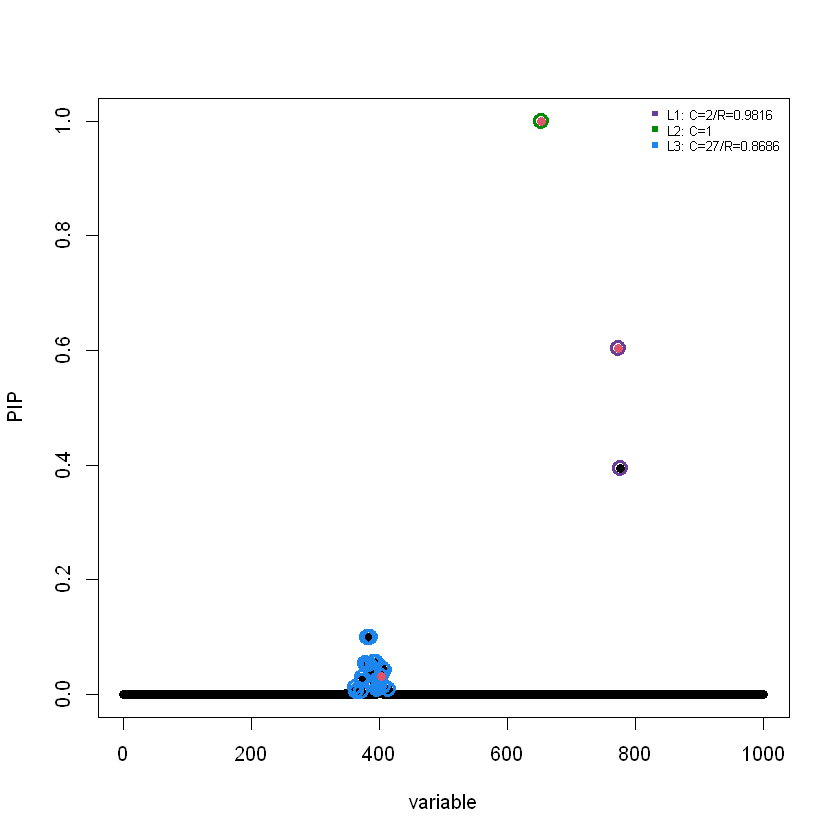

In [28]:
susie_plot(fitted, y="PIP", b=b, add_legend=T)

The true effect variables are colored red, and the three 95% CS identified are
circled in different colors. 

-------------------------------------------

**Question 8: Recall the true effect variables we know before running any susie, and for the variable 403, what is the PIP? What's the average PIP of the 3rd CS? Is the PIP for variable 403 higher or lower than the average, and why is that?**

Hint: You can use the code below to compare $-log_{10}$ p-value and PIP for the CS containing variable 403:

```R
    i  <- fitted$sets$cs$L3
    z3 <- cbind(i,log10p[i],fitted$pip[i])
    colnames(z3) <- c('position', '-log10 pvalue', 'PIP')
    z3[order(z3[,2], decreasing = TRUE),]
```

**Answer:**

In [29]:
i  <- fitted$sets$cs$L3
z3 <- cbind(i, log10p[i], fitted$pip[i])
colnames(z3) <- c('position', '-log10 pvalue', 'PIP')
z3[order(z3[, 2], decreasing = TRUE), ]
z3[which(z3[, 1] == 403), 3]
mean(z3[,3])
mean(z3[,3]) < z3[which(z3[, 1] == 403), 3]

position,-log10 pvalue,PIP
396,6.676732,0.056704331
381,6.618518,0.100360243
386,6.618518,0.100360243
379,6.417587,0.054179507
391,6.396640,0.055952118
383,6.370810,0.052896918
384,6.370810,0.052896918
389,6.360493,0.042161265
405,6.331181,0.045761975
403,6.322861,0.031992848


PIP 
0.03199285

[1] 0.03533265

PIP 
FALSE

The PIP for 403th variant is 0.031992848 which is less than the average PIP of the 3rd CS. 
I suspect that the possible reason is that the third CS contains too many variants, causing the PIP of the true variant 403 to be absorbed by other variants.

***

**Question 9: Please rerun the `susie` analysis setting `L=1` to detect a maximum of only one effect across the region. How does the result compare to the previous section of "one causal effect" fine-mapping using likelihoods from univariate analysis?**

**Answer:**

In [30]:
fitted <- susie(X, y, L = 1)
print(fitted$sets)

HINT: For an X with many columns, please consider installingthe Rfast package for more efficient credible set (CS)calculations.



$cs
$cs$L1
[1] 773 777


$purity
   min.abs.corr mean.abs.corr median.abs.corr
L1    0.9815726     0.9815726       0.9815726

$cs_index
[1] 1

$coverage
[1] 0.9968218

$requested_coverage
[1] 0.95



The result is same as the results we got from previous section of "one causal effect" fine-mapping.

-------------------------------------------

## Choice of prior effect size

In SuSiE, the prior effect size is parameterized by the percentage of variance explained by a variable, $h_j^2$. 
By default, SuSiE estimates $h_j^2$ and uses it as the prior (an empirical Bayes approach). 
Here we demonstrate fixing the prior effect size to 0.2, i.e., we believe a non-zero effect variable can explain 20% variation in quantitative trait values:

HINT: For an X with many columns, please consider installingthe Rfast package for more efficient credible set (CS)calculations.



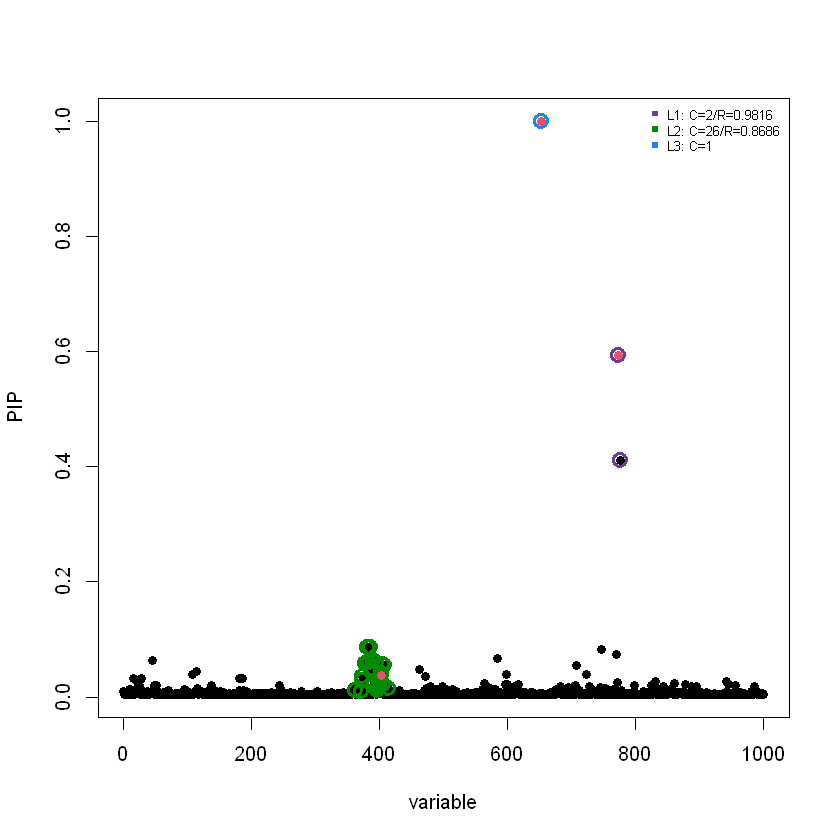

In [31]:
fitted2 = susie(X, y, L = 10, estimate_prior_variance = FALSE, scaled_prior_variance = 0.2)
susie_plot(fitted2, y='PIP', b=b, add_legend=T)

The result is very similar to when prior effects are estimated. 

-------------------------------------------

**Question 10: Please change `scaled_prior_variance` to different numbers between 0 and 1, and examine the results. What happens if you set it to 0.001, and why?**

**Answer:**

HINT: For an X with many columns, please consider installingthe Rfast package for more efficient credible set (CS)calculations.



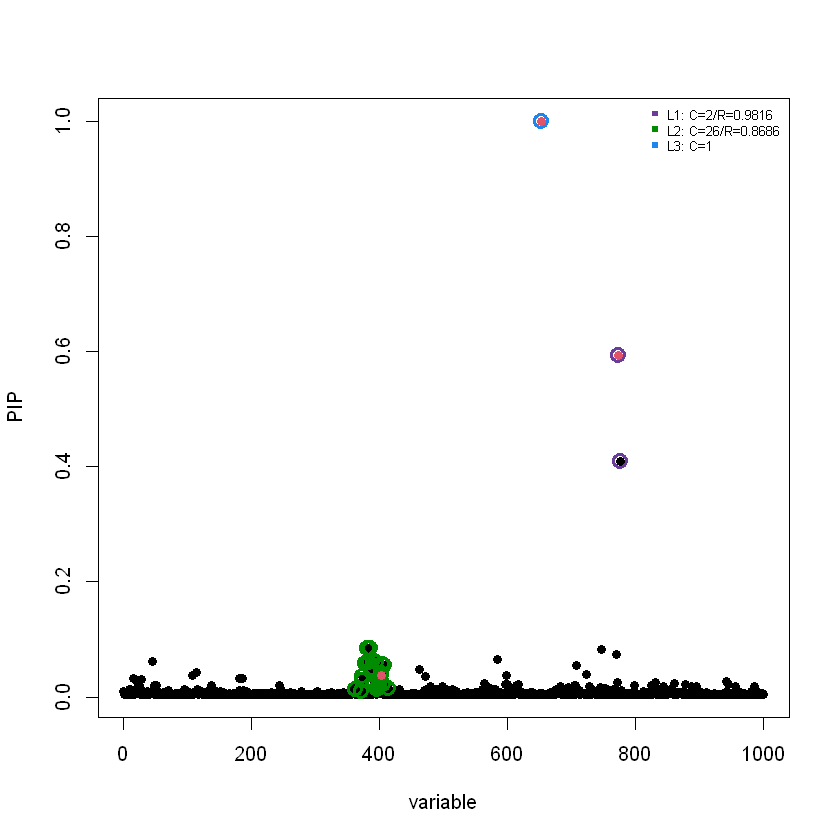

In [33]:
fitted3 = susie(
  X,
  y,
  L = 10,
  estimate_prior_variance = FALSE,
  scaled_prior_variance = 0.1
)
susie_plot(fitted3,
           y = 'PIP',
           b = b,
           add_legend = T)

HINT: For an X with many columns, please consider installingthe Rfast package for more efficient credible set (CS)calculations.



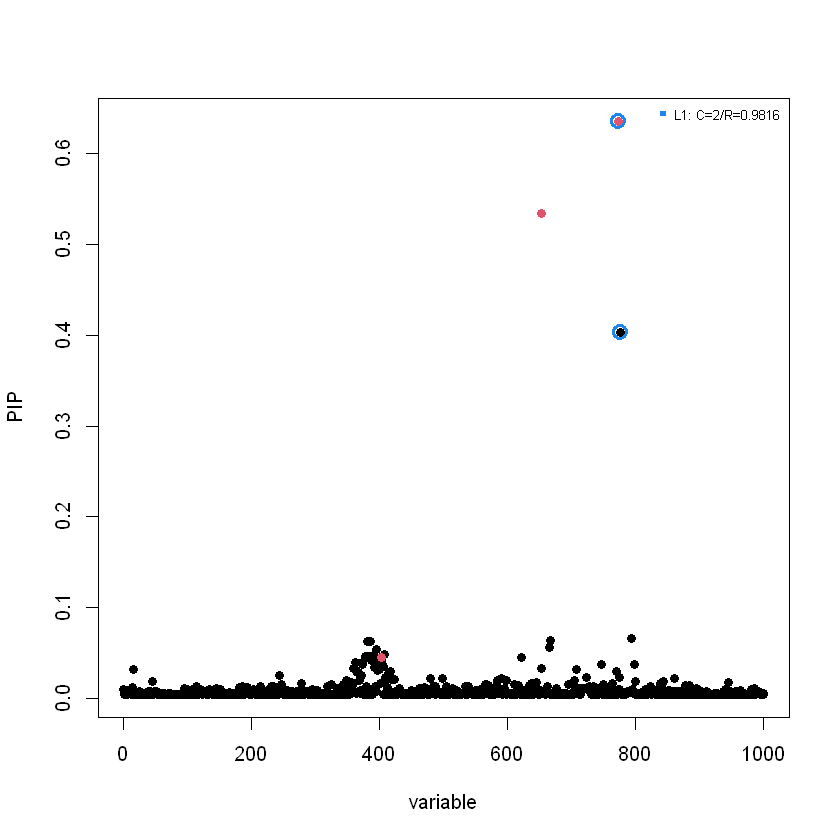

In [39]:
fitted4 = susie(
  X,
  y,
  L = 10,
  estimate_prior_variance = FALSE,
  scaled_prior_variance = 0.002
)
susie_plot(fitted4,
           y = 'PIP',
           b = b,
           add_legend = T)

HINT: For an X with many columns, please consider installingthe Rfast package for more efficient credible set (CS)calculations.



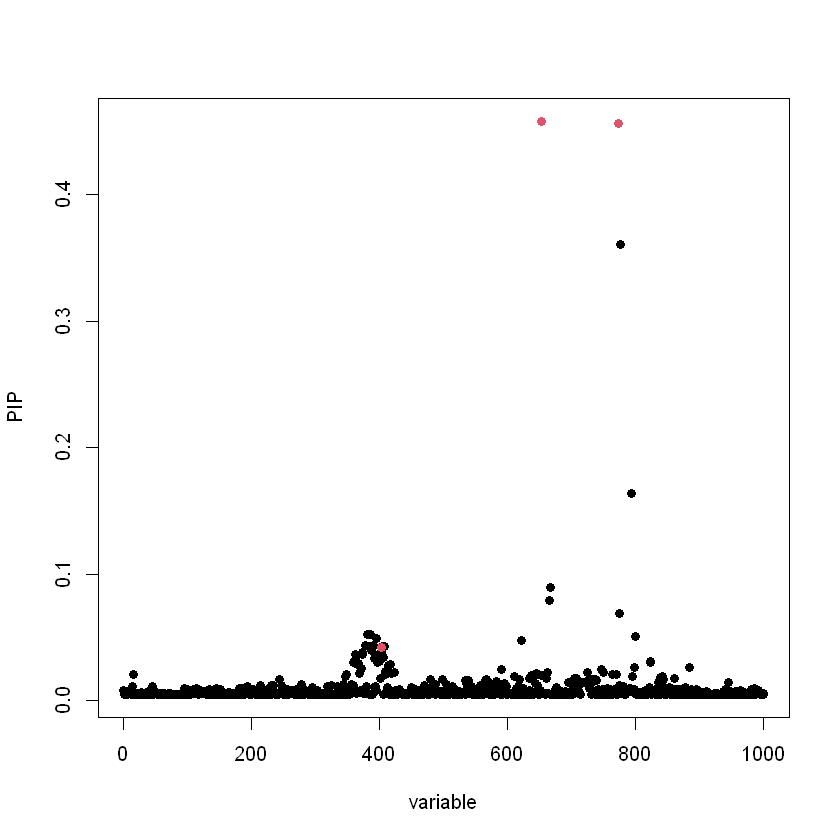

In [41]:
fitted5 = susie(
  X,
  y,
  L = 10,
  estimate_prior_variance = FALSE,
  scaled_prior_variance = 0.001
)
susie_plot(fitted5,
           y = 'PIP',
           b = b,
           add_legend = T)

We can find if we fix the prior effect size instead of estimating it, when I transfer the prior variance from 0.2 to 0.001, the number of CS decreases from 3 to 0. We can't even find a CS when the prior variance was set to 0.001. 

Setting the prior effect size to 0.001 in SuSiE assumes that each non-zero effect variable explains only 0.1% of the trait variance. This leads to smaller estimated effect sizes, making the model more conservative in selecting variables. As a result, fewer SNPs may be identified as significant, and their Posterior Inclusion Probability (PIP) could decrease, potentially missing true causal variants. 

-------------------------------------------

# Fine-mapping with summary statistics via `susie_rss`

Summary statistics of genetic association studies typically contain effect size ($\hat{\beta}$ coefficient from regression), p-value and minor allele frequencies. 
These information can be used to perform fine-mapping with given an additional input of correlation matrix between variables.
The correlation matrix in genetics is typically referred to as LD matrix (LD for linkage disequilibrium). 
One may use external reference panels to estimate it when this matrix cannot be obtained from samples directly. There is a potential problem using LD from reference panel, and we demonstrated it in the next section.
Caution that LD matrix here has to be correlation matrix $r$, not $r^2$ or $|r|$.

We have previously computed z-scores for this data-set. The correlation matrix can be computed directly from $X$ matrix, 

In [42]:
R <- cor(X)

SuSiE regression with summary statistics is implemented as `susie_rss` function, 

In [43]:
fitted_rss <- susie_rss(z_scores, R, L = 10)


HINT: For large R or large XtX, consider installing the Rfast package for better performance.



We compare the PIP obtained with previous analysis using individual level data,

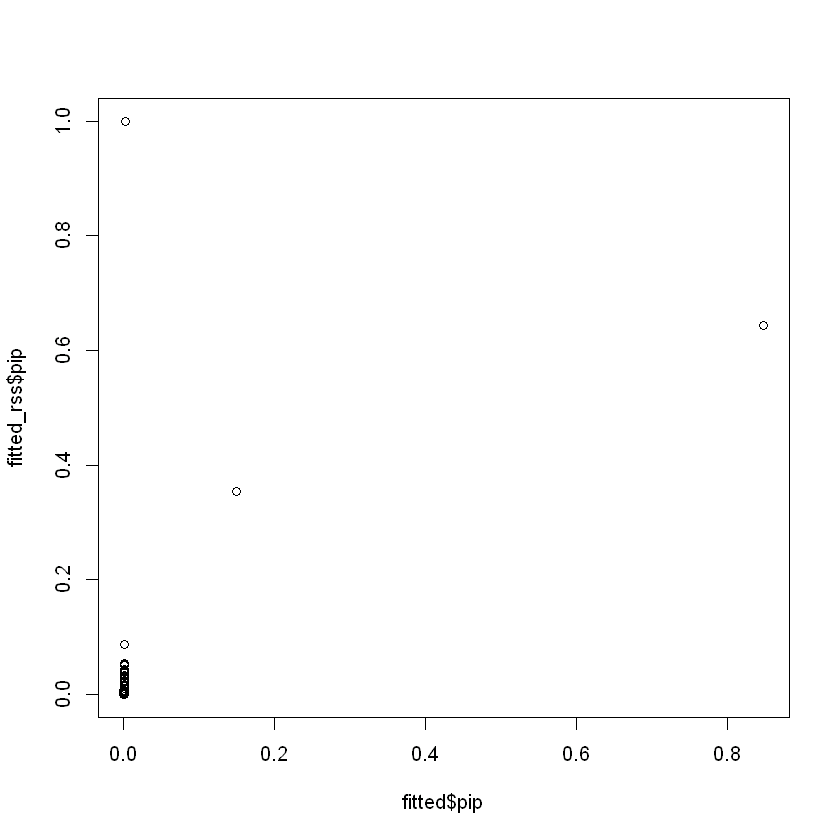

In [44]:
plot(fitted$pip, fitted_rss$pip, ylim=c(0,1))

The results very much agree. This is expected when the summary statistics are indeed derived from the individual level data.

## Use LD from external reference data

When original genotype information is not available, 
one may use reference panel to estimate LD matrix. 
False discoveries may occur if the LD pattern from the reference panel does not agree well with the original sample. 

To illustrate, we randomly generated 500 samples from $N(0,R)$ and treated them as reference panel genotype matrix `X_ref`.

In [45]:
set.seed(1234)
tmp = matrix(rnorm(500*1001), 500, 1001)
eigenR = eigen(R)
eigenR$values[eigenR$values < 1e-10] = 0
X_ref = tmp %*% (eigenR$values * t(eigenR$vectors))
R_ref = cor(X_ref)

Using `susie_rss` function with LD from reference panel,


HINT: For large R or large XtX, consider installing the Rfast package for better performance.



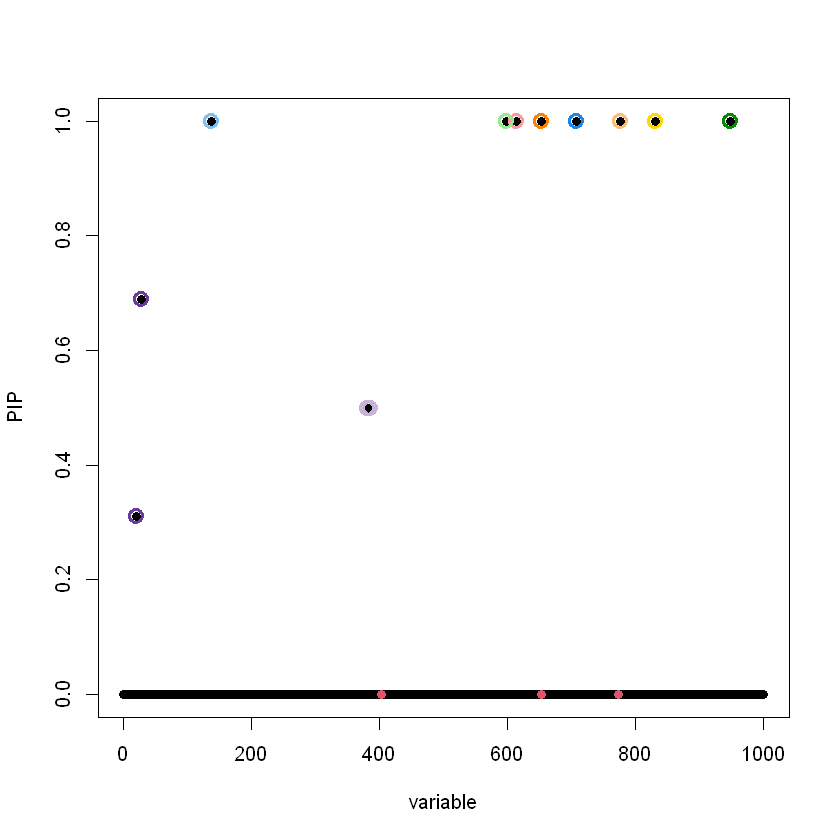

In [46]:
fitted_rss_ref <- susie_rss(z_scores, R_ref, L = 10)
susie_plot(fitted_rss_ref, y="PIP", b=b)

-------------------------------------------

**Question 11: Please compare and comment on the CS reported using reference LD panel versus using the correct LD computed from genotype data. Are there any false discoveries?**

**Answer:**

We can find, if we use the reference LD panel, we can get so many different CS. What's more, we can't find the true variant in any CS. The result got from reference LD panel performs bad. 

-------------------------------------------

We recommend the following modification to the LD matrix when reference panel ($R_{ref}$) are used,
$$
\tilde{R} = \text{cov2cor}((1-w)R_{ref}+ w zz^\intercal)),
$$
where z is the original summary statistics. We suggest using $w = 1/n_{ref}$, $n_{ref}$ is the sample size from the reference panel. The modified LD matrix becomes
$$
\tilde{R} = \text{cov2cor}(\frac{n_{ref}-1}{n_{ref}}R_{ref}+ \frac{1}{n_{ref}} zz^\intercal)) = \text{cov2cor}(\frac{1}{n_{ref}}(X_{ref}^\intercal X_{ref}+ zz^\intercal)),
$$
where `X_ref` is column-standardized. This modification is implemented in `susie_rss` with parameter `z_ld_weight`:



HINT: For large R or large XtX, consider installing the Rfast package for better performance.



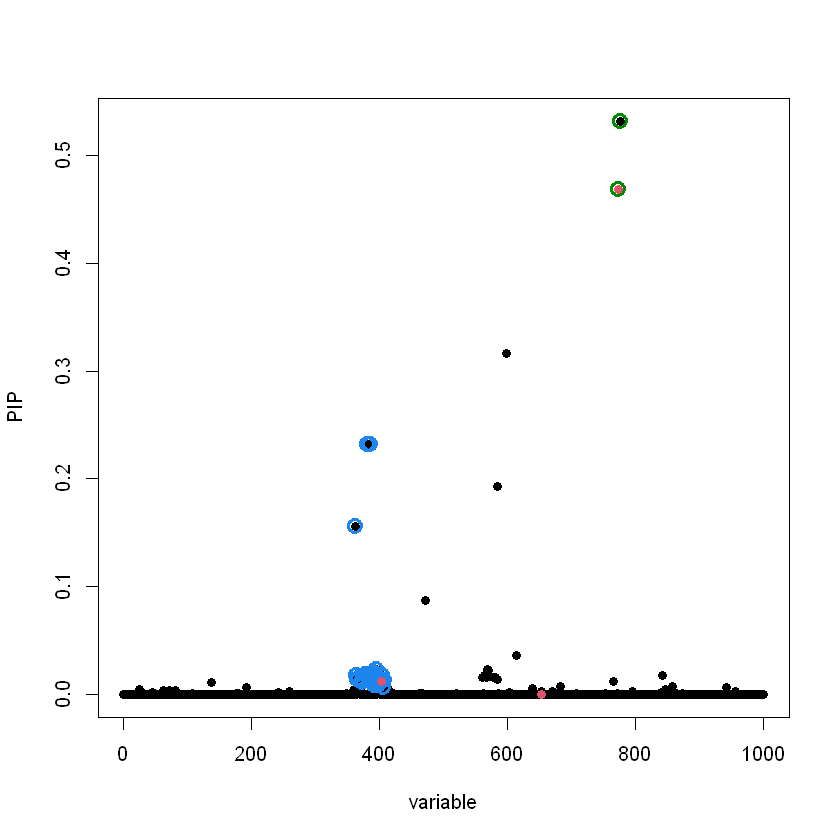

In [47]:
n_ref = 500
fitted_rss_ref_corrected <- susie_rss(z_scores, R_ref, z_ld_weight = 1/n_ref, L = 10)
susie_plot(fitted_rss_ref_corrected, y="PIP", b=b)

***
**Question 12: Please compare and comment on the results using adjusted reference LD panel. Is the result improved?**

**Answer:**

We can observe a significant improvement in the results. First, we identified two CS, and in both CS, we were able to find the true variants. This aligns with our previous findings, although the previous method identified three CS.

***

# Exercise: fine-mapping analysis on a different data-set

Please load and analyze another data-set provided in `susieR` package:

In [57]:
rm(list=ls())
library(susieR)
data(N2finemapping)

Please use the same R code for `N3finemapping` data to analyze this new data-set, similarly focusing on the first column of the phenotype matrix as the phenotype of interest. 
This data-set contains two true effect variables. However, as you are soon to find out in univariate linear regression analysis, **the lead SNP via univariate analysis is neither of the two effect variables**.

-------------------------------------------

**Question 13: please run `susie_rss` on the N2finemapping dataset and report the results below. Does it capture any true effect variant?**

**Answer:**

[1] 337 999

[1] -0.5357235  0.7524393


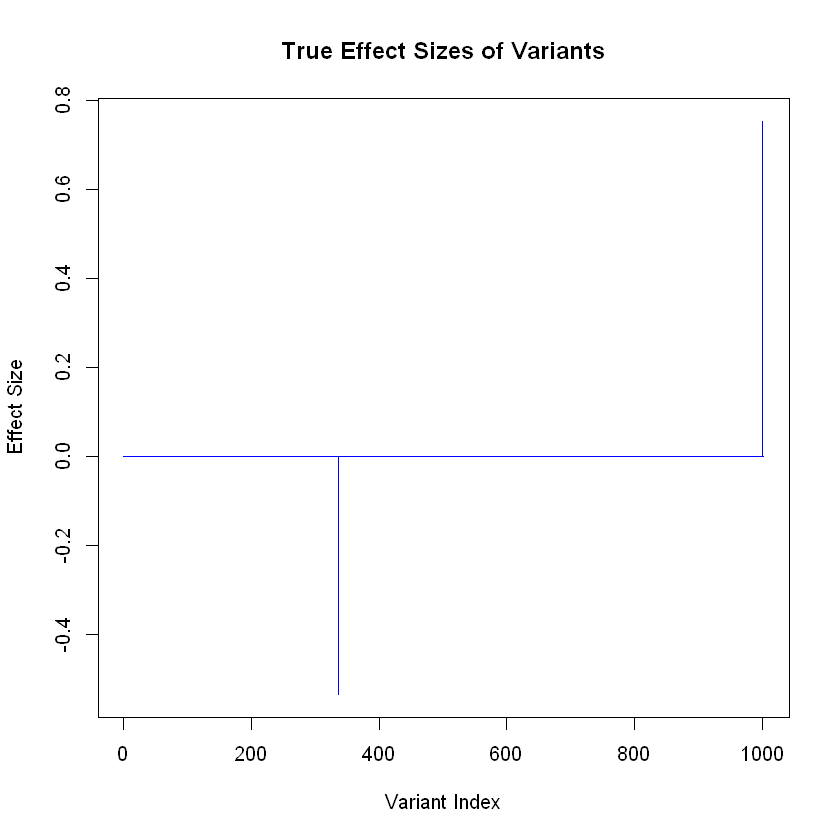

In [62]:
y = Y[,1]
b = true_coef[,1]
which(b != 0)

plot(
  b,
  type = "h",
  col = "blue",
  main = "True Effect Sizes of Variants",
  xlab = "Variant Index",
  ylab = "Effect Size"
)

effect_sizes = b[which(b != 0)]
print(effect_sizes)

In [64]:
sumstats = univariate_regression(X, y)
effect_sizes
sumstats$betahat[which(b != 0)]

[1] -0.5357235  0.7524393

[1] -0.3472976  0.5720599

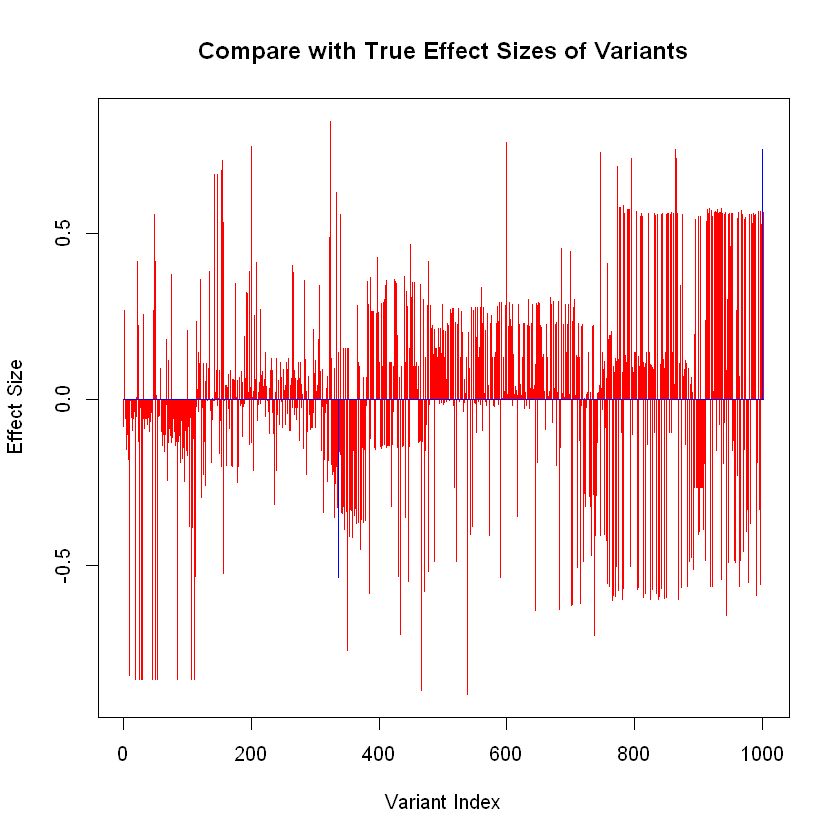

In [65]:
plot(
  sumstats$betahat,
  type = "h",
  col = "red",
  main = "Compare with True Effect Sizes of Variants",
  xlab = "Variant Index",
  ylab = "Effect Size"
)
lines(b, type = "h", col = "blue")

In [66]:
z_scores = sumstats$betahat / sumstats$sebetahat
log10p = -log10(pchisq(z_scores^2,1,lower.tail=F))
length(which(log10p > -log10(5 * 10 ^ (-8))))

[1] 133

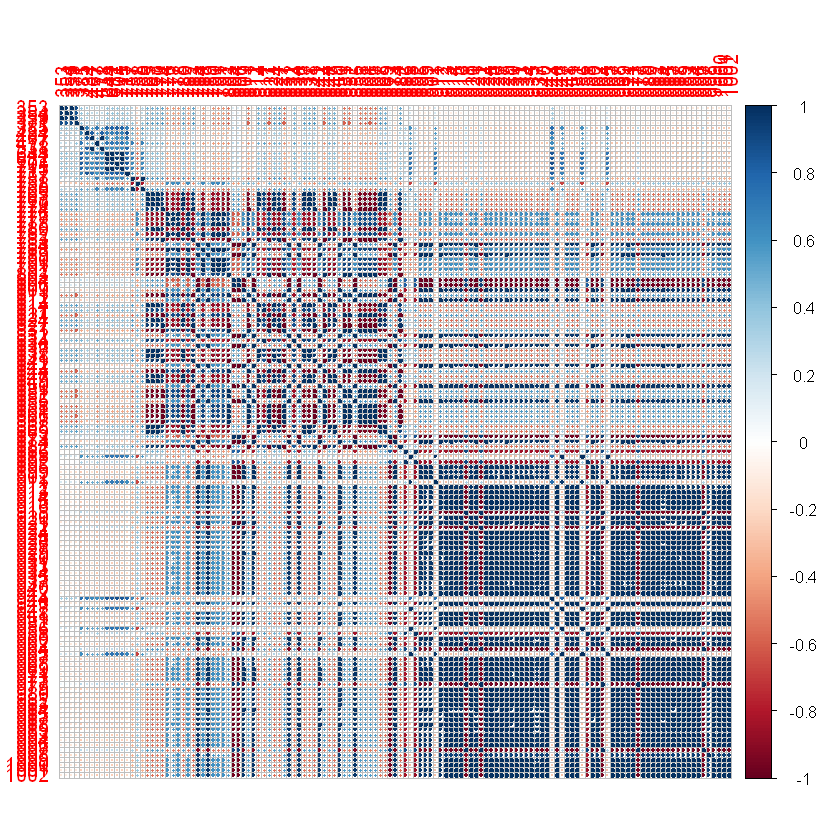

In [67]:
X_matrix = X[,which(log10p > -log10(5 * 10 ^ (-8)))]
colnames(X_matrix) = which(log10p > -log10(5 * 10 ^ (-8)))
cor_matrix = cor(X_matrix, use = "pairwise.complete.obs")
corrplot(cor_matrix)

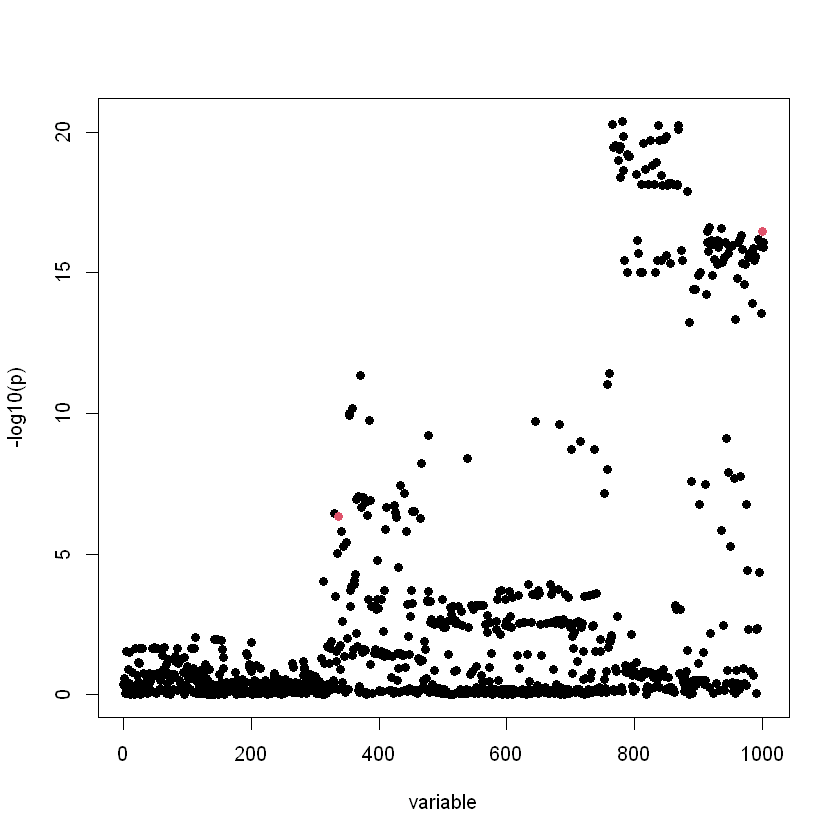

In [68]:
susie_plot(z_scores,y="z",b=b)

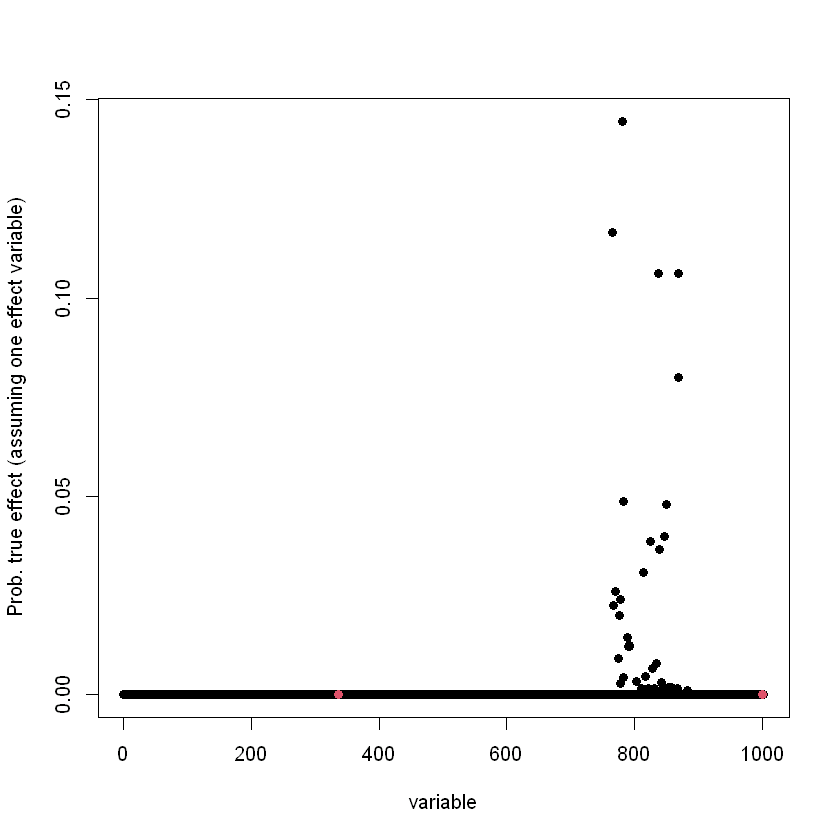

In [70]:
lliks = sapply(1:ncol(X), function(i)
  logLik(lm(y ~ X[, i])))
lliks = lliks - max(lliks) # To avoid taking exp on large numbers in the next line, thus improving numerical stability
probs = exp(lliks) / sum(exp(lliks))

susie_plot(probs, 
           y = "PIP", 
           b = b, 
           ylab = "Prob. true effect (assuming one effect variable)")

performs bad here.

In [71]:
which(susieR:::in_CS(t(probs), coverage = 0.95) != 0)

[1] 765 767 770 774 776 778 780 782 788 790 791 792 814 824 834 837 838 847 849
[20] 868 869

In [85]:
fitted <- susie(X, y, L = 10)
print(fitted$sets)

HINT: For an X with many columns, please consider installingthe Rfast package for more efficient credible set (CS)calculations.



$cs
$cs$L2
 [1]  850  913  914  915  916  920  924  925  926  927  930  931  933  934  935
[16]  942  946  948  951  952  962  967  968  979  980  982  983  985  988  989
[31]  993  994  996  999 1000 1001 1002

$cs$L3
[1] 337 379 440


$purity
   min.abs.corr mean.abs.corr median.abs.corr
L2    0.9722386     0.9938064       0.9947184
L3    0.8534981     0.8775989       0.8848378

$cs_index
[1] 2 3

$coverage
[1] 0.9545920 0.9696759

$requested_coverage
[1] 0.95



Performs well, and we can find two true variants in two CS separately.


HINT: For large R or large XtX, consider installing the Rfast package for better performance.



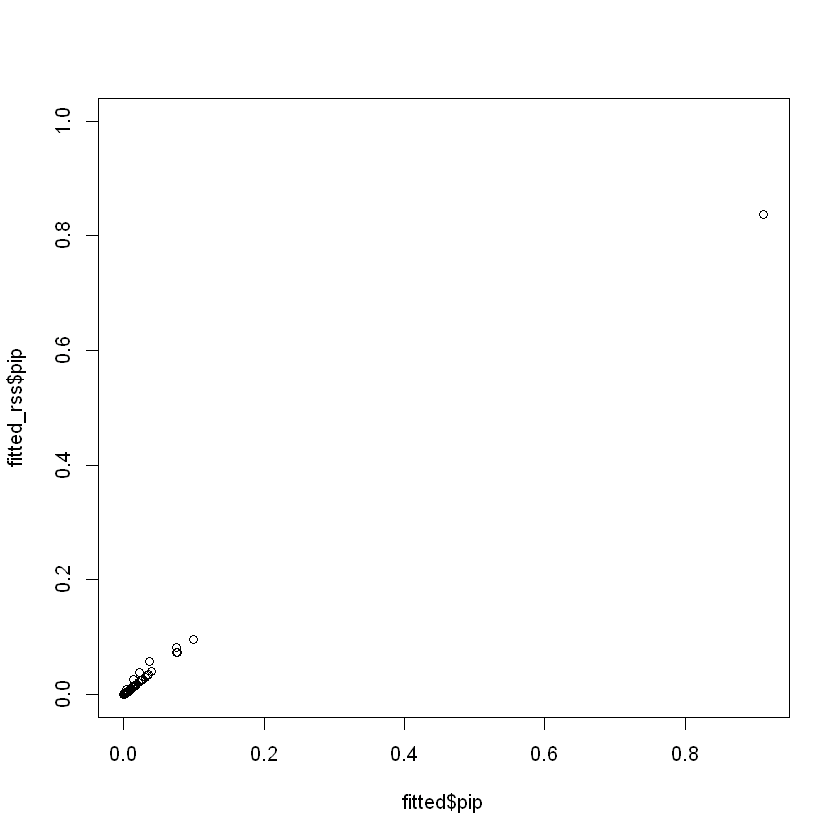

In [84]:
R <- cor(X)
fitted_rss <- susie_rss(z_scores, R, L = 10)
plot(fitted$pip, fitted_rss$pip, ylim=c(0,1))



HINT: For large R or large XtX, consider installing the Rfast package for better performance.

Warning message in susie_suff_stat(XtX = R, Xty = z, n = 2, yty = 1, scaled_prior_variance = prior_variance, :
"IBSS algorithm did not converge in 100 iterations!
                  Please check consistency between summary statistics and LD matrix.
                  See https://stephenslab.github.io/susieR/articles/susierss_diagnostic.html"


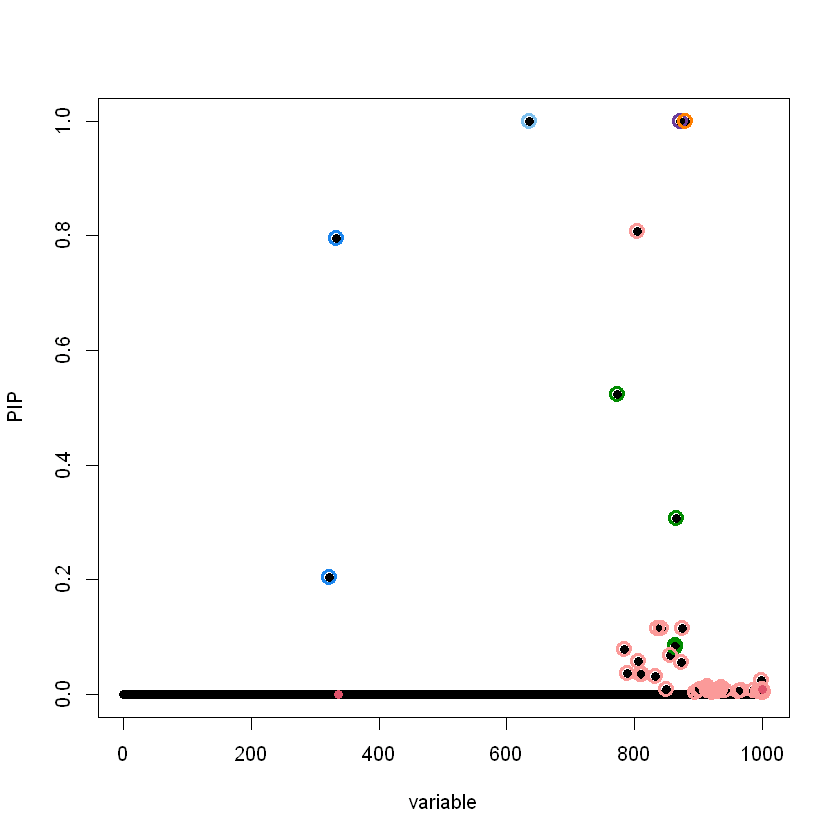

In [86]:
set.seed(1234)
tmp = matrix(rnorm(500*1002), 500, 1002)
eigenR = eigen(R)
eigenR$values[eigenR$values < 1e-10] = 0
X_ref = tmp %*% (eigenR$values * t(eigenR$vectors))
R_ref = cor(X_ref)

n_ref = 500
fitted_rss_ref_corrected <-
  susie_rss(z_scores, R_ref, z_ld_weight = 1 / n_ref, L = 10)
susie_plot(fitted_rss_ref_corrected, y = "PIP", b = b)

Through the above process, we identified two true variants: 337 and 999. Using the One Causal Variant method makes it difficult to detect the true variants. However, applying the Sum of Single Effects (SuSiE) model yields better results, as we were able to identify two CS, each containing one of the true variants.

If we have genotype data, we can compute cor(X), and SuSiE regression with summary statistics is implemented as the susie_rss function. The results obtained using this method are consistent with those from SuSiE.

If X is unknown, we can modify the LD matrix to obtain ref_X, which still helps in identifying the true variants. However, in this case, we were only able to detect variant 999, indicating that the method is less effective.

-------------------------------------------

In [87]:
sessionInfo()

R version 4.3.1 (2023-06-16 ucrt)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 11 x64 (build 26100)

Matrix products: default


locale:
[1] LC_COLLATE=Chinese (Simplified)_China.utf8 
[2] LC_CTYPE=Chinese (Simplified)_China.utf8   
[3] LC_MONETARY=Chinese (Simplified)_China.utf8
[4] LC_NUMERIC=C                               
[5] LC_TIME=Chinese (Simplified)_China.utf8    

time zone: America/New_York
tzcode source: internal

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] corrplot_0.95  susieR_0.12.35

loaded via a namespace (and not attached):
 [1] Matrix_1.6-4      gtable_0.3.4      jsonlite_1.8.8    dplyr_1.1.4      
 [5] compiler_4.3.1    crayon_1.5.3      tidyselect_1.2.0  Rcpp_1.0.11      
 [9] IRdisplay_1.1     scales_1.3.0      uuid_1.2-1        fastmap_1.1.1    
[13] IRkernel_1.3.2    lattice_0.21-8    ggplot2_3.5.1     R6_2.5.1         
[17] plyr_1.8.9        generics_0.1.3   